In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                     | 0/50000 [00:00<?, ?it/s]

  7%|███████▍                                                                                               | 3637/50000 [00:00<00:01, 36364.14it/s]

 15%|███████████████▉                                                                                       | 7747/50000 [00:00<00:01, 39146.59it/s]

 24%|████████████████████████▏                                                                             | 11854/50000 [00:00<00:00, 40020.76it/s]

 32%|████████████████████████████████▎                                                                     | 15857/50000 [00:00<00:00, 39844.27it/s]

 40%|█████████████████████████████████████████                                                             | 20135/50000 [00:00<00:00, 40896.16it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 24360/50000 [00:00<00:00, 41354.55it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 28529/50000 [00:00<00:00, 41460.37it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 32676/50000 [00:00<00:00, 40384.49it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 36721/50000 [00:00<00:00, 39756.57it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 40941/50000 [00:01<00:00, 40492.30it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 45179/50000 [00:01<00:00, 41060.00it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49290/50000 [00:01<00:00, 38468.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 39741.71it/s]

Files already downloaded and verified


  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]

 36%|████████████████████████████████████▉                                                                  | 3592/10000 [00:00<00:00, 35911.99it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 7521/10000 [00:00<00:00, 37896.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 36975.98it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 z89ot7fb


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-z89ot7fb:best, 314.60MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_ftr = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_ftr = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_ftr = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_ftr = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_ftr = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_ftr.extend(ftr.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_ftr.extend(ftr.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_ftr.extend(ftr.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_ftr.extend(ftr.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_ftr.extend(ftr.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                       | 0/625 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/625 [00:00<06:03,  1.72it/s]

  2%|██▎                                                                                                           | 13/625 [00:00<00:24, 24.96it/s]

  4%|████▌                                                                                                         | 26/625 [00:00<00:12, 47.67it/s]

  6%|███████                                                                                                       | 40/625 [00:00<00:08, 69.47it/s]

  9%|█████████▌                                                                                                    | 54/625 [00:00<00:06, 86.61it/s]

 11%|███████████▊                                                                                                  | 67/625 [00:01<00:05, 97.86it/s]

 13%|█████████████▉                                                                                               | 80/625 [00:01<00:05, 106.47it/s]

 15%|████████████████▏                                                                                            | 93/625 [00:01<00:04, 112.89it/s]

 17%|██████████████████▎                                                                                         | 106/625 [00:01<00:04, 117.55it/s]

 19%|████████████████████▌                                                                                       | 119/625 [00:01<00:04, 121.05it/s]

 21%|██████████████████████▊                                                                                     | 132/625 [00:01<00:03, 123.50it/s]

 23%|█████████████████████████                                                                                   | 145/625 [00:01<00:03, 125.10it/s]

 25%|███████████████████████████▎                                                                                | 158/625 [00:01<00:03, 126.19it/s]

 27%|█████████████████████████████▌                                                                              | 171/625 [00:01<00:03, 126.97it/s]

 29%|███████████████████████████████▊                                                                            | 184/625 [00:01<00:03, 127.45it/s]

 32%|██████████████████████████████████                                                                          | 197/625 [00:02<00:03, 127.49it/s]

 34%|████████████████████████████████████▎                                                                       | 210/625 [00:02<00:03, 126.72it/s]

 36%|██████████████████████████████████████▌                                                                     | 223/625 [00:02<00:03, 126.91it/s]

 38%|████████████████████████████████████████▊                                                                   | 236/625 [00:02<00:03, 127.44it/s]

 40%|███████████████████████████████████████████                                                                 | 249/625 [00:02<00:02, 128.17it/s]

 42%|█████████████████████████████████████████████▎                                                              | 262/625 [00:02<00:02, 128.63it/s]

 44%|███████████████████████████████████████████████▌                                                            | 275/625 [00:02<00:02, 129.02it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 288/625 [00:02<00:02, 129.15it/s]

 48%|████████████████████████████████████████████████████                                                        | 301/625 [00:02<00:02, 129.12it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 314/625 [00:03<00:02, 129.00it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 327/625 [00:03<00:02, 129.16it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 340/625 [00:03<00:02, 129.24it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 353/625 [00:03<00:02, 129.33it/s]

 59%|███████████████████████████████████████████████████████████████▏                                            | 366/625 [00:03<00:02, 129.35it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 379/625 [00:03<00:01, 129.20it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 392/625 [00:03<00:01, 128.89it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 405/625 [00:03<00:01, 127.93it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 418/625 [00:03<00:01, 128.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 431/625 [00:03<00:01, 128.63it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 444/625 [00:04<00:01, 128.92it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 457/625 [00:04<00:01, 129.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 470/625 [00:04<00:01, 129.21it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 483/625 [00:04<00:01, 129.34it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 496/625 [00:04<00:00, 129.45it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 509/625 [00:04<00:00, 129.42it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 522/625 [00:04<00:00, 129.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 536/625 [00:04<00:00, 129.68it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 549/625 [00:04<00:00, 129.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 562/625 [00:04<00:00, 129.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 575/625 [00:05<00:00, 129.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 589/625 [00:05<00:00, 129.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 602/625 [00:05<00:00, 129.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 615/625 [00:05<00:00, 129.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:05<00:00, 114.89it/s]

train - OK


  0%|                                                                                                                       | 0/157 [00:00<?, ?it/s]

  1%|▋                                                                                                              | 1/157 [00:00<00:26,  5.99it/s]

  9%|█████████▊                                                                                                    | 14/157 [00:00<00:02, 62.74it/s]

 18%|███████████████████▌                                                                                          | 28/157 [00:00<00:01, 90.79it/s]

 27%|█████████████████████████████▏                                                                               | 42/157 [00:00<00:01, 105.73it/s]

 35%|██████████████████████████████████████▏                                                                      | 55/157 [00:00<00:00, 111.64it/s]

 44%|███████████████████████████████████████████████▉                                                             | 69/157 [00:00<00:00, 118.19it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 83/157 [00:00<00:00, 122.16it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 97/157 [00:00<00:00, 125.10it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 111/157 [00:01<00:00, 127.18it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 125/157 [00:01<00:00, 128.27it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 138/157 [00:01<00:00, 128.68it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 151/157 [00:01<00:00, 128.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 106.35it/s]

val - OK


  0%|                                                                                                                       | 0/157 [00:00<?, ?it/s]

  1%|▋                                                                                                              | 1/157 [00:00<00:28,  5.53it/s]

  9%|█████████▊                                                                                                    | 14/157 [00:00<00:02, 59.90it/s]

 18%|███████████████████▌                                                                                          | 28/157 [00:00<00:01, 88.32it/s]

 27%|█████████████████████████████▏                                                                               | 42/157 [00:00<00:01, 103.96it/s]

 35%|██████████████████████████████████████▏                                                                      | 55/157 [00:00<00:00, 112.39it/s]

 43%|███████████████████████████████████████████████▏                                                             | 68/157 [00:00<00:00, 117.75it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 81/157 [00:00<00:00, 121.42it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 94/157 [00:00<00:00, 123.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 107/157 [00:00<00:00, 125.64it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 120/157 [00:01<00:00, 126.72it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 133/157 [00:01<00:00, 127.61it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 146/157 [00:01<00:00, 128.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 109.50it/s]

test InD - OK


  0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

 14%|███████████████▎                                                                                             | 14/100 [00:00<00:00, 132.74it/s]

 28%|██████████████████████████████▌                                                                              | 28/100 [00:00<00:00, 134.31it/s]

 42%|█████████████████████████████████████████████▊                                                               | 42/100 [00:00<00:00, 135.79it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 56/100 [00:00<00:00, 136.02it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 70/100 [00:00<00:00, 136.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 84/100 [00:00<00:00, 136.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 98/100 [00:00<00:00, 136.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 135.95it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(40000, 3, 32, 32) (40000, 2048) (40000, 512) (40000, 10) (40000,)
(10000, 3, 32, 32) (10000, 2048) (10000, 512) (10000, 10) (10000,)
(10000, 3, 32, 32) (10000, 2048) (10000, 512) (10000, 10) (10000,)
(6400, 3, 32, 32) (6400, 2048) (6400, 512) (6400, 10)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


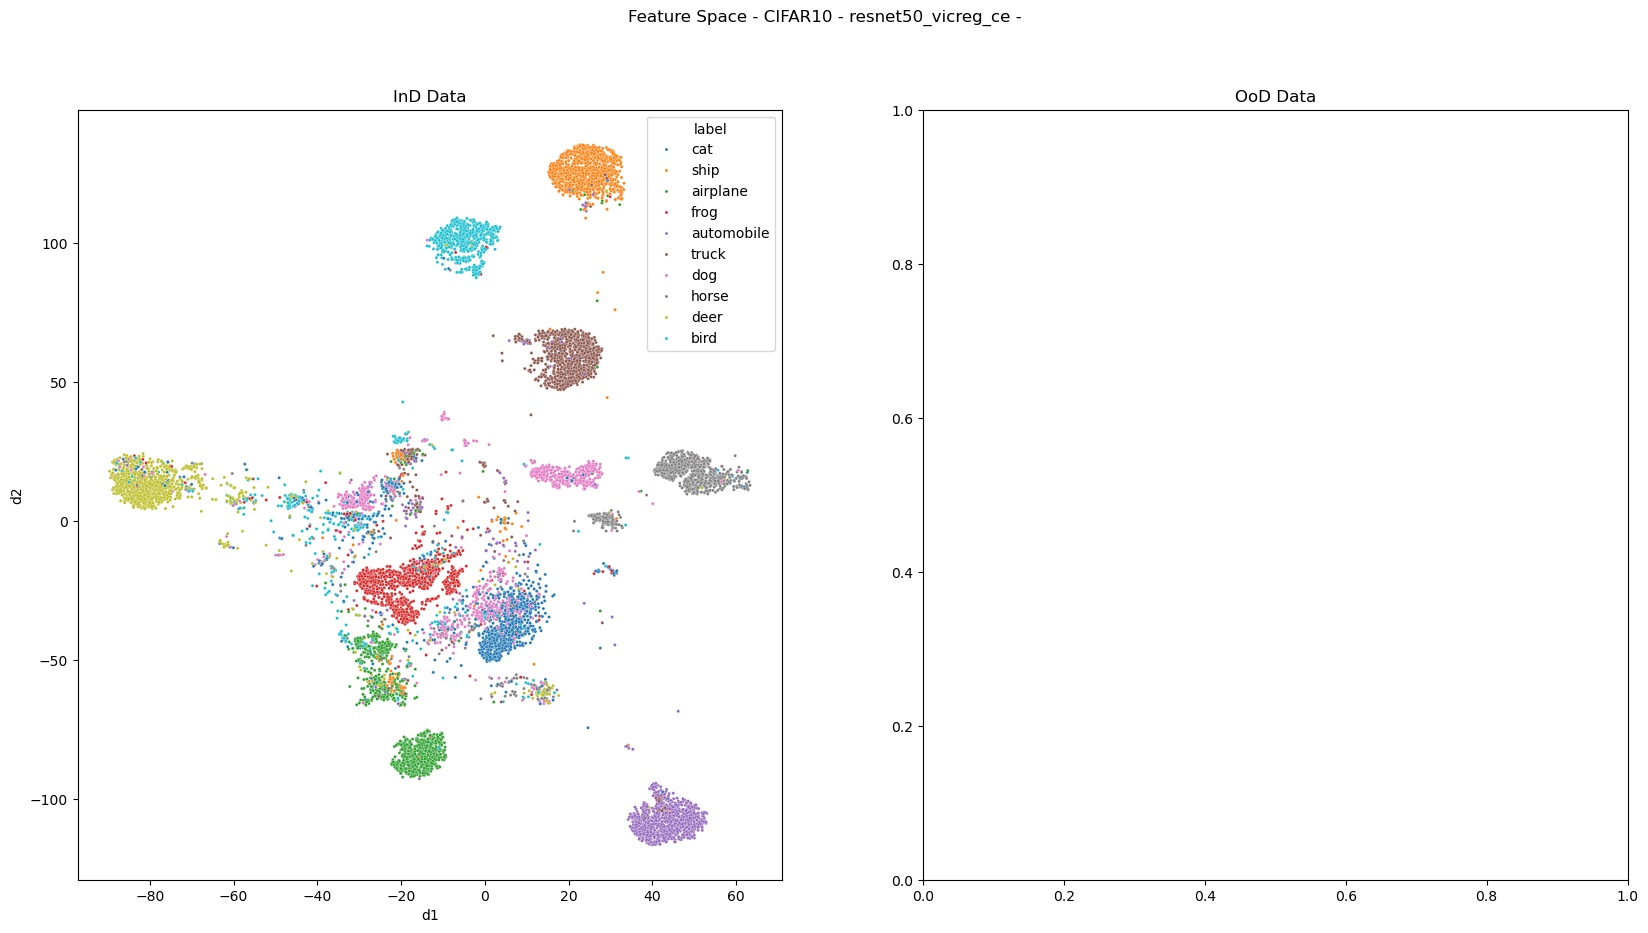

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

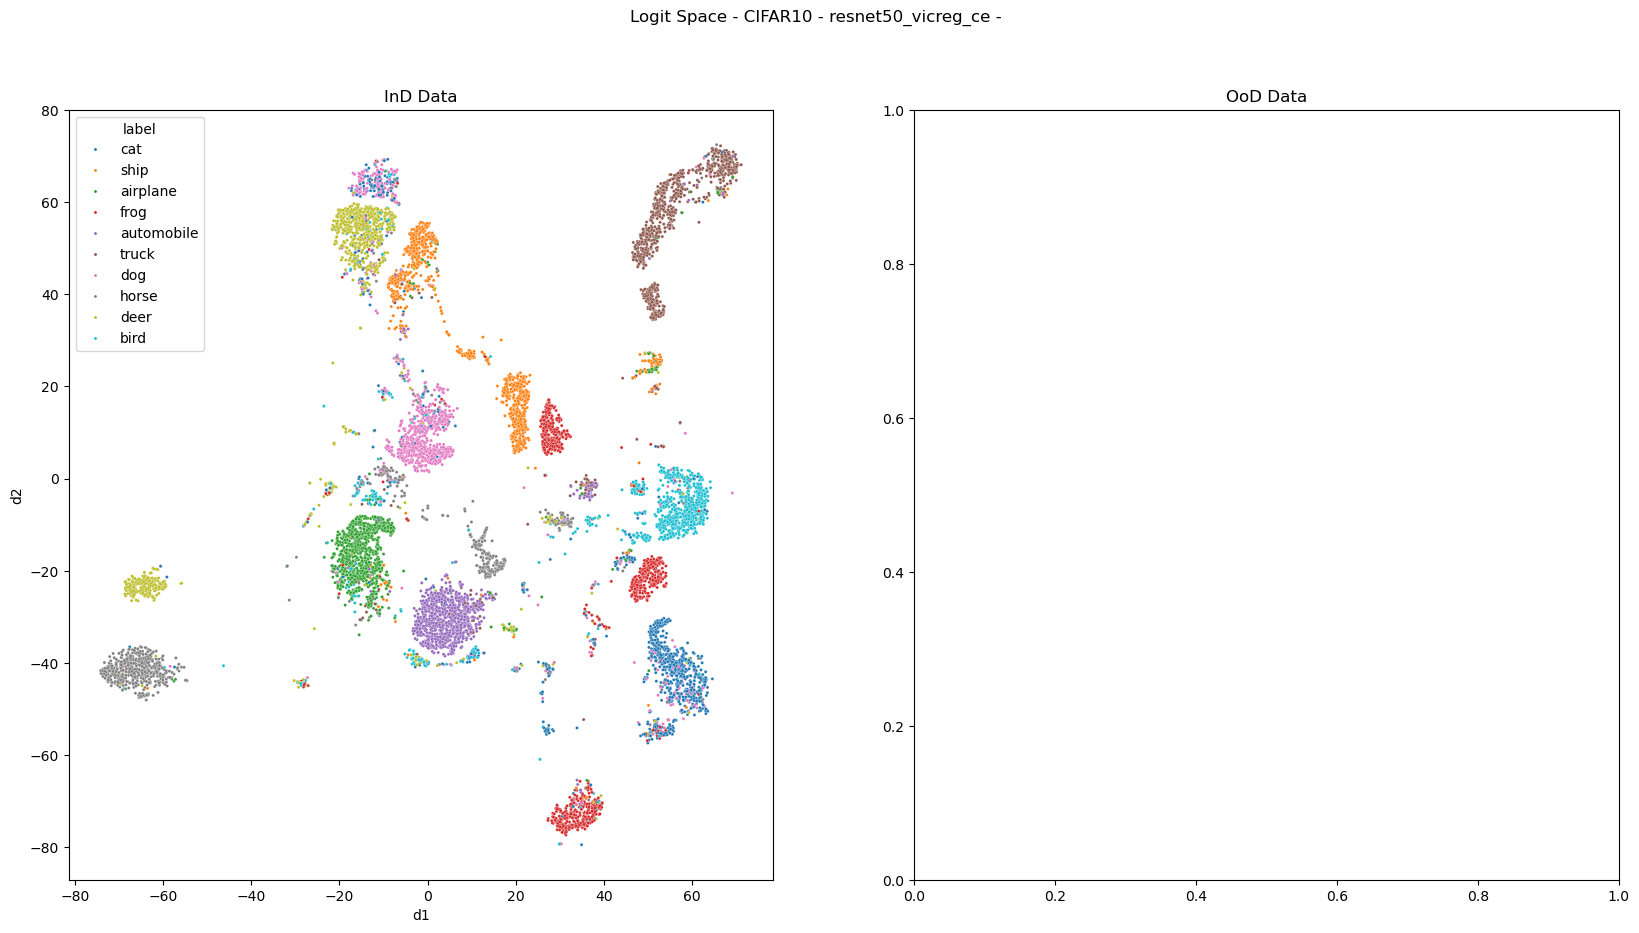

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:07,  2.39s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.49s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:07<00:02,  2.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.45s/it]

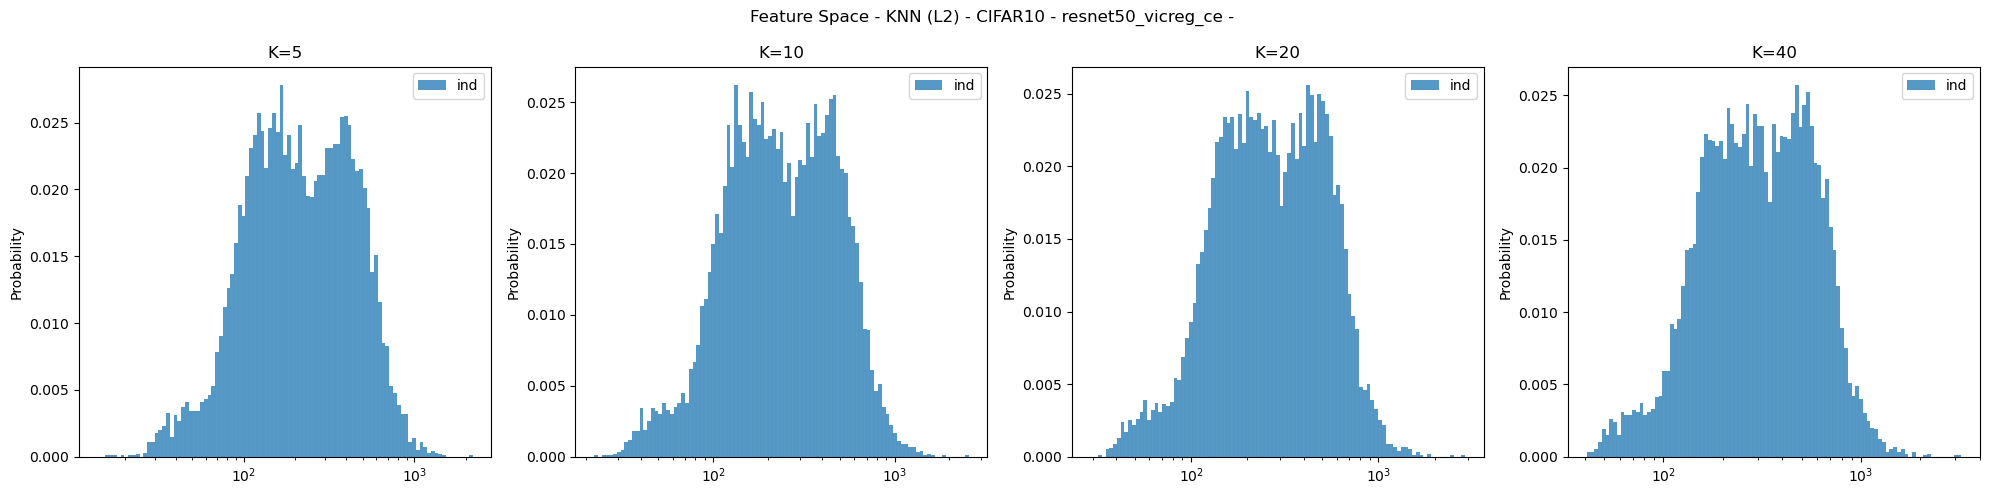

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:07,  2.35s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.37s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:07<00:02,  2.39s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.39s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.39s/it]

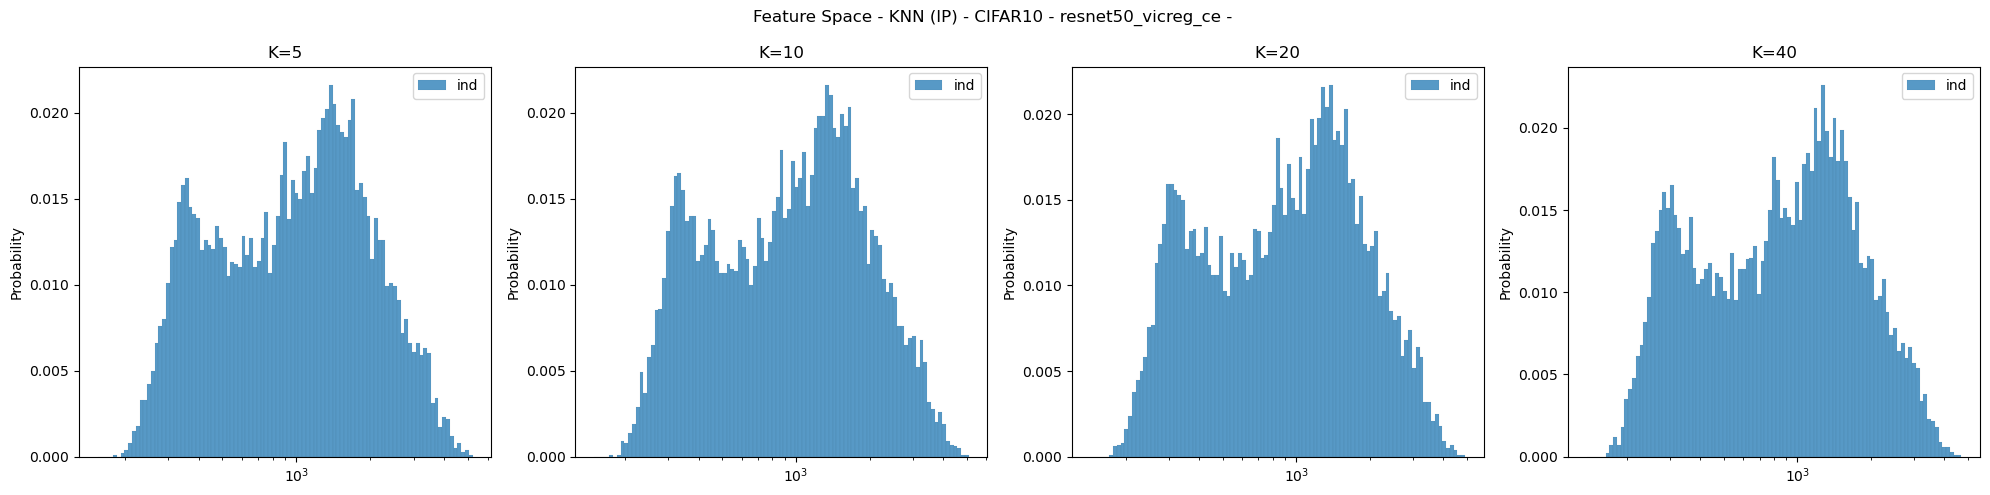

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:06,  2.32s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.32s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:07<00:02,  2.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.41s/it]

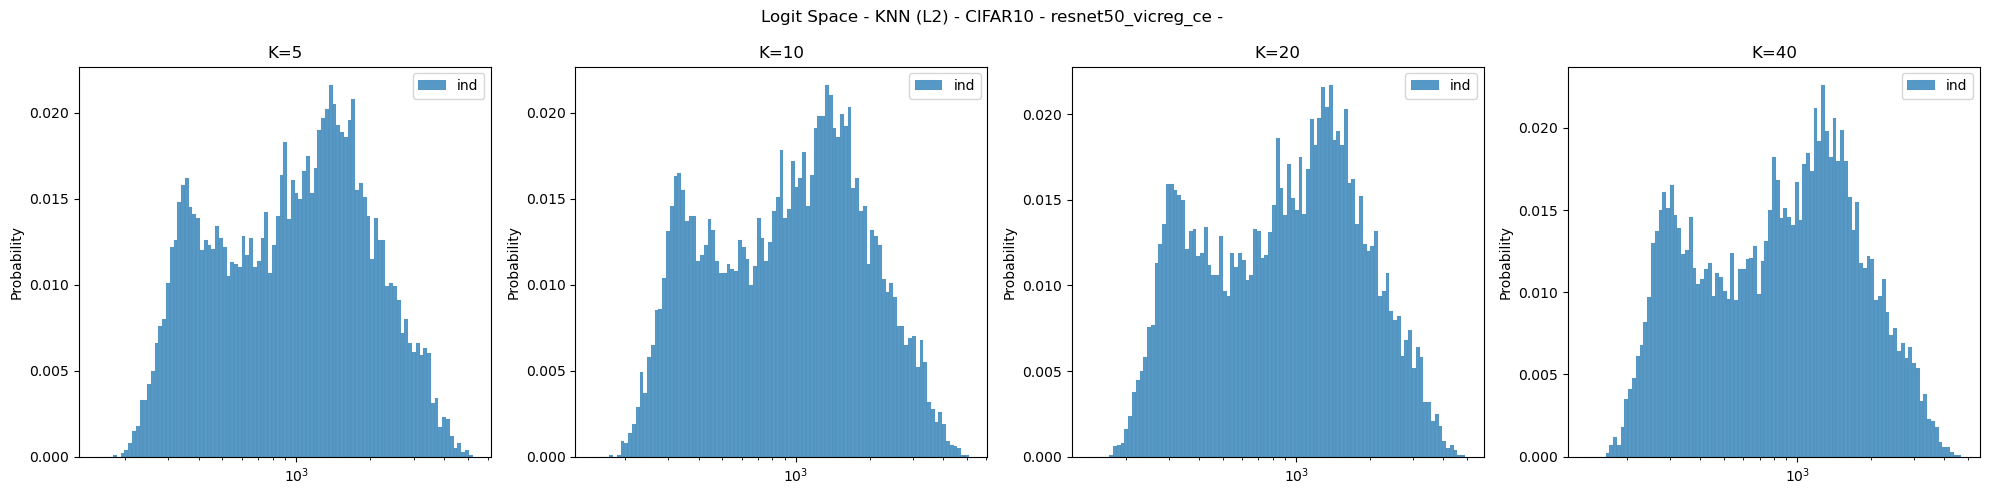

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:06,  2.31s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.31s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:06<00:02,  2.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.34s/it]

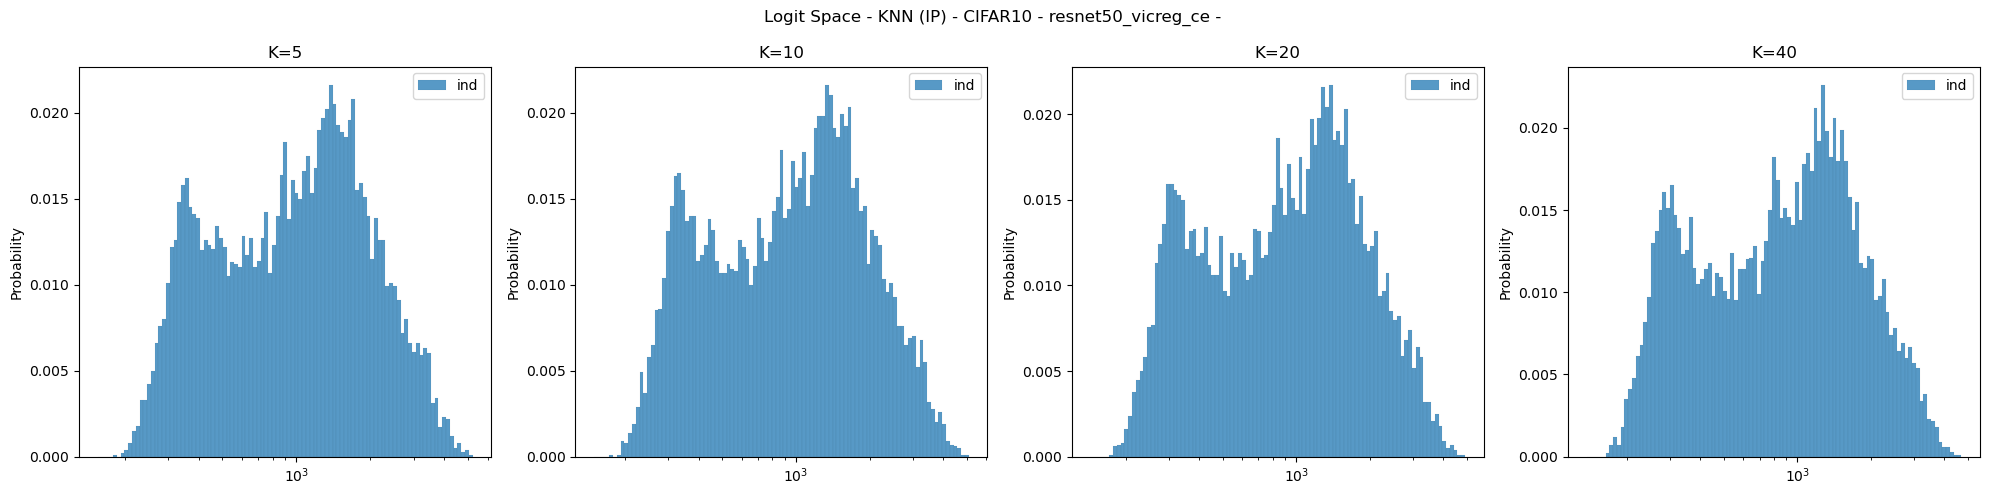

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

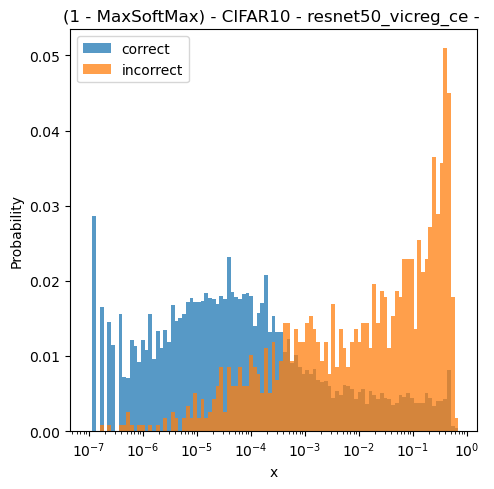

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()